<a href="https://colab.research.google.com/github/SafaaFathii/Head_Pose_Estimation_Python/blob/main/notebooks/ML_I_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [156]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [157]:
#!unzip /content/drive/MyDrive/ML1ProjectFinal/AFLW2000-3D.zip

In [158]:
%%capture
!pip install mediapipe

In [159]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from sklearn.preprocessing import MinMaxScaler
from math import cos, sin
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.model_selection import train_test_split
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow

In [160]:
DATA_PATH = "https://github.com/SafaaFathii/Head_Pose_Estimation_Python/upload/main/src/data"

In [161]:
import glob
imgsList = []
for filename in glob.iglob("/content/AFLW2000" + '**/*.jpg', recursive=True):
    imgsList.append(filename)
imgsList = [s.replace("/content/AFLW2000/", "") for s in imgsList]
imgsList = [s.replace(".jpg", "") for s in imgsList]

In [162]:
len(imgsList)

2000

In [163]:
import scipy.io
mat = scipy.io.loadmat('/content/AFLW2000/image00053.mat')
mat

{'Color_Para': array([[0.8049162 , 0.8424407 , 0.95360756, 0.17904064, 0.11229751,
         0.06208982, 1.        ]], dtype=float32),
 'Exp_Para': array([[-0.43254565],
        [-0.49546558],
        [-0.0245161 ],
        [-0.12564901],
        [ 0.069844  ],
        [-0.5443459 ],
        [-0.33797911],
        [ 0.08202856],
        [ 0.0040714 ],
        [-0.37175666],
        [ 0.92511695],
        [-0.4717894 ],
        [-0.06613012],
        [ 0.10192859],
        [ 0.18888453],
        [-0.25701   ],
        [ 0.01145714],
        [ 0.00919155],
        [-0.02989736],
        [-0.16416246],
        [ 0.02201216],
        [-0.17920862],
        [ 0.01966132],
        [ 0.1707678 ],
        [-0.20631359],
        [-0.01053302],
        [ 0.024297  ],
        [-0.05838199],
        [-0.0239272 ]]),
 'Illum_Para': array([[ 1.08063674e+00,  1.08041036e+00,  1.08572924e+00,
         -4.97283787e-03,  8.73530060e-02,  2.11133853e-01,
          1.43381929e+00,  2.33793169e-01,  0.00000

In [164]:
df = pd.DataFrame(columns = ['ImgName','yaw', 'pitch', 'roll'])
df['ImgName'] = imgsList

In [165]:
LandMarks_df = pd.DataFrame()

In [166]:
# choosing random image
random_file = 'image00053'
relatives = []
for img in imgsList:
    
    faceModule = mediapipe.solutions.face_mesh
    # loading image and its correspinding mat file
    with faceModule.FaceMesh(static_image_mode=True) as faces:
        # loading the image
        image = cv2.imread('/content/AFLW2000/'+img+'.jpg')
        mat = scipy.io.loadmat('/content/AFLW2000/'+img+'.mat')
        YawPitchRoll = mat['Pose_Para'][0][:3] 
        pitch = YawPitchRoll[0]
        yaw = YawPitchRoll[1]
        roll = YawPitchRoll[2]
        df.loc[df.ImgName==img,'yaw'] = yaw
        df.loc[df.ImgName==img,'pitch'] = pitch
        df.loc[df.ImgName==img,'roll'] = roll

        # processing the face to extract the landmark points (468 point) for each x,y,z
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        MyList1 = []
        if results.multi_face_landmarks != None: 
        # looping over the faces in the image
            for face in results.multi_face_landmarks:
                for landmark in face.landmark:
                    x = landmark.x
                    y = landmark.y
                    # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                    shape = image.shape 
                    relative_x = x * shape[1]
                    relative_y = y * shape[0]
                    MyList1.extend([relative_x,relative_y])
                    cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,0), 2)
                    cv2.circle(image, (int(relative_x),int( relative_y)), radius=1, color=(0, 255, 0), thickness=2)
            #cv2_imshow(image)
            #print( df['yaw'])
        relatives.append(np.array(MyList1,dtype=np.float32))

In [167]:
# # choosing random image
# random_file = 'image00053'
# relatives = []
# for img in imgsList:
    
#     faceModule = mediapipe.solutions.face_mesh
#     # loading image and its correspinding mat file
#     with faceModule.FaceMesh(static_image_mode=True) as faces:
#         # loading the image
#         image = cv2.imread('/content/AFLW2000/'+img+'.jpg')
#         mat = scipy.io.loadmat('/content/AFLW2000/'+img+'.mat')
#         YawPitchRoll = mat['Pose_Para'][0][:3] 
#         pitch = YawPitchRoll[0]
#         yaw = YawPitchRoll[1]
#         roll = YawPitchRoll[2]
#         df.loc[df.ImgName==img,'yaw'] = yaw
#         df.loc[df.ImgName==img,'pitch'] = pitch
#         df.loc[df.ImgName==img,'roll'] = roll

#         # processing the face to extract the landmark points (468 point) for each x,y,z
#         results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#         MyList1 = []
#         if results.multi_face_landmarks != None: 
#         # looping over the faces in the image
#             for face in results.multi_face_landmarks:
#                 for landmark in face.landmark:
#                     x = landmark.x
#                     y = landmark.y
#                     # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
#                     shape = image.shape 
#                     relative_x = int(x * shape[1])
#                     relative_y = int(y * shape[0])
#                     MyList1.extend([relative_x,relative_y])
#                     #cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
#                     cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
#             #cv2_imshow(image)
#             #print( df['yaw'])
#         relatives.append(np.array(MyList1,dtype=np.float32))

In [168]:
LandMarks_df = pd.DataFrame(relatives)
LandMarks_df

,0,1,2,3,4,5,6,7,8,9,...,926,927,928,929,930,931,932,933,934,935
0,223.444214,304.433044,220.837616,272.732025,222.586685,283.397064,213.053177,242.969940,220.254776,262.880585,...,246.840027,220.160324,241.243210,222.316177,237.853226,223.580811,291.326050,211.526688,295.953247,208.375336
1,208.509476,316.331116,189.195648,291.880707,207.179718,296.968903,190.655090,260.643433,186.005539,283.868195,...,237.731506,221.738129,231.685593,226.187653,225.979431,230.345184,280.250702,214.392838,286.161316,205.801361
2,231.186569,315.969910,228.629837,291.539429,229.099762,296.345642,217.130142,255.010345,227.765015,281.983765,...,247.726807,213.418610,242.559464,217.430878,239.942352,221.081863,295.887299,197.083679,299.986725,193.833405
3,203.365952,293.837860,198.755966,270.277313,207.513397,278.355560,205.329819,246.493958,199.046631,263.487244,...,246.202789,234.131958,241.143280,235.184891,236.826721,236.195114,282.624573,241.524338,287.624847,239.919067
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,230.847916,298.916534,245.287369,281.888855,234.040924,284.261536,238.767166,257.440399,247.594925,275.962830,...,245.777679,229.167618,244.220200,232.165176,244.667191,235.083633,269.403656,224.542297,272.286102,220.757095
1996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997,194.755173,281.685547,199.000992,254.432953,202.788406,266.069489,208.914612,233.080582,201.512146,246.957153,...,250.955902,230.586960,245.469009,230.450836,241.027618,229.965012,287.404877,240.580765,294.095490,238.917068
1998,255.552856,284.567108,260.062012,248.978897,252.810455,265.455505,242.409088,225.138397,259.546265,239.156006,...,254.976425,216.727295,251.897110,217.521896,251.589249,217.017746,289.828217,216.432541,293.413239,212.517883


In [169]:
df

,ImgName,yaw,pitch,roll
0,image00972,0.066288,0.075391,-0.07608
1,image04180,0.752342,-0.514121,-0.341487
2,image01086,-0.027759,-0.347319,-0.091287
3,image00334,0.567679,-0.029032,0.240908
4,image03075,-1.025425,1.079903,-1.493768
...,...,...,...,...
1995,image02775,-0.478792,-0.537956,0.254959
1996,image02958,1.15883,-1.394595,-1.806607
1997,image03890,0.604873,0.282187,0.474036
1998,image00104,-0.32851,0.38624,-0.109401


In [170]:
df_final = LandMarks_df

In [171]:
df_final['yaw']=df['yaw']
df_final['pitch']=df['pitch']
df_final['roll']=df['roll']
df_final['ImgName']=df['ImgName']

In [172]:
df_final.dropna(inplace = True)

In [173]:
df_final

,0,1,2,3,4,5,6,7,8,9,...,930,931,932,933,934,935,yaw,pitch,roll,ImgName
0,223.444214,304.433044,220.837616,272.732025,222.586685,283.397064,213.053177,242.969940,220.254776,262.880585,...,237.853226,223.580811,291.326050,211.526688,295.953247,208.375336,0.066288,0.075391,-0.07608,image00972
1,208.509476,316.331116,189.195648,291.880707,207.179718,296.968903,190.655090,260.643433,186.005539,283.868195,...,225.979431,230.345184,280.250702,214.392838,286.161316,205.801361,0.752342,-0.514121,-0.341487,image04180
2,231.186569,315.969910,228.629837,291.539429,229.099762,296.345642,217.130142,255.010345,227.765015,281.983765,...,239.942352,221.081863,295.887299,197.083679,299.986725,193.833405,-0.027759,-0.347319,-0.091287,image01086
3,203.365952,293.837860,198.755966,270.277313,207.513397,278.355560,205.329819,246.493958,199.046631,263.487244,...,236.826721,236.195114,282.624573,241.524338,287.624847,239.919067,0.567679,-0.029032,0.240908,image00334
5,193.870773,276.432373,210.798096,245.080383,209.219223,261.192719,229.363312,224.625488,216.797745,237.355865,...,267.277557,237.286636,316.681396,271.780090,324.790588,272.518799,0.223025,0.442086,0.786156,image00862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,195.593811,290.162170,198.433487,255.851944,205.025406,270.610870,210.615585,227.719604,201.108276,246.178162,...,252.085617,222.838455,312.193298,236.729858,320.370056,234.445099,0.667445,0.210636,0.484012,image00728
1994,229.144257,299.622162,218.288757,278.403107,224.216980,284.151855,210.728012,254.527695,216.419983,271.090759,...,230.399017,233.792221,272.110535,218.256622,275.814789,214.854080,0.24994,-0.11961,-0.19251,image03732
1995,230.847916,298.916534,245.287369,281.888855,234.040924,284.261536,238.767166,257.440399,247.594925,275.962830,...,244.667191,235.083633,269.403656,224.542297,272.286102,220.757095,-0.478792,-0.537956,0.254959,image02775
1997,194.755173,281.685547,199.000992,254.432953,202.788406,266.069489,208.914612,233.080582,201.512146,246.957153,...,241.027618,229.965012,287.404877,240.580765,294.095490,238.917068,0.604873,0.282187,0.474036,image03890


In [174]:
df_final.to_csv("TrainingData.csv",index=False)

In [175]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):
    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        faceModule = mediapipe.solutions.face_mesh
        with faceModule.FaceMesh(static_image_mode=True) as faces:      
            results = faces.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            tdx = int(results.multi_face_landmarks[0].landmark[4].x * img.shape[1])
            tdy = int(results.multi_face_landmarks[0].landmark[4].y * img.shape[0])

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [176]:
df = pd.read_csv("TrainingData.csv",index_col = "ImgName")
df.head()

,0,1,2,3,4,5,6,7,8,9,...,929,930,931,932,933,934,935,yaw,pitch,roll
ImgName,,,,,,,,,,,,,,,,,,,,,
image00972,223.444214,304.433044,220.837616,272.732025,222.586685,283.397064,213.053177,242.969940,220.254776,262.880585,...,222.316177,237.853226,223.580811,291.326050,211.526688,295.953247,208.375336,0.066288,0.075391,-0.076080
image04180,208.509476,316.331116,189.195648,291.880707,207.179718,296.968903,190.655090,260.643433,186.005539,283.868195,...,226.187653,225.979431,230.345184,280.250702,214.392838,286.161316,205.801361,0.752342,-0.514120,-0.341487
image01086,231.186569,315.969910,228.629837,291.539429,229.099762,296.345642,217.130142,255.010345,227.765015,281.983765,...,217.430878,239.942352,221.081863,295.887299,197.083679,299.986725,193.833405,-0.027759,-0.347319,-0.091287
image00334,203.365952,293.837860,198.755966,270.277313,207.513397,278.355560,205.329819,246.493958,199.046631,263.487244,...,235.184891,236.826721,236.195114,282.624573,241.524338,287.624847,239.919067,0.567679,-0.029032,0.240908
image00862,193.870773,276.432373,210.798096,245.080383,209.219223,261.192719,229.363312,224.625488,216.797745,237.355865,...,240.144562,267.277557,237.286636,316.681396,271.780090,324.790588,272.518799,0.223025,0.442086,0.786156


In [177]:
random_file = 'image00862'

In [178]:
df.loc[random_file,'1']

276.432373046875

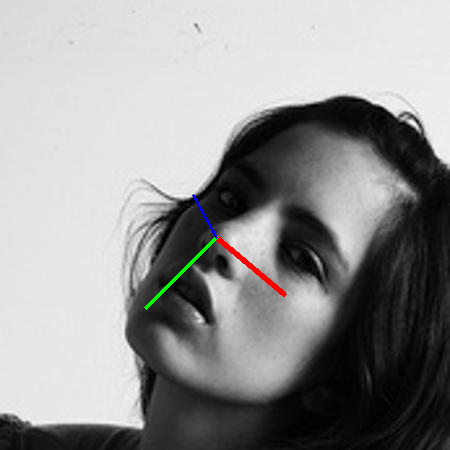

In [179]:
image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('/content/AFLW2000/'+random_file+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
cv2_imshow(draw_axis(image,pitch,yaw,roll))

## MODELS

In [180]:
df.shape

(1853, 939)

In [201]:
df = df.sample(frac=1).reset_index(drop=True)

In [202]:
X = df.drop(['yaw','pitch','roll'],axis = 1)

In [203]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50).fit(X)
pca_df = pd.DataFrame(pca.transform(X), columns = ['pca_' + str(i) for i in range(50)])
X=pca_df

In [204]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [205]:
y = df[['yaw','pitch','roll']]

In [206]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [207]:
y_train.shape

(1482, 3)

In [208]:
X_test.shape

(371, 50)

In [209]:
X_train.shape

(1482, 50)

In [210]:
model = LinearRegression()
model.fit(X_train, y_train['yaw'])
pred = model.predict(X_test)
print("YAW MSE:",np.sqrt(mean_squared_error(y_test['yaw'], pred)))
print("score YAW",model.score(X_test, y_test['yaw'])) 

YAW MSE: 0.13869834420798943
score YAW 0.9383201285068317


In [211]:
model = LinearRegression()
model.fit(X_train, y_train['pitch'])
pred = model.predict(X_test)
print("PITCH MSE:",np.sqrt(mean_squared_error(y_test['pitch'], pred)))
print("score PITCH",model.score(X_test, y_test['pitch'])) 

PITCH MSE: 0.24243290069983586
score PITCH 0.3135623264512323


In [212]:
model = LinearRegression()
model.fit(X_train, y_train['roll'])
pred = model.predict(X_test)
print("ROLL MSE:",np.sqrt(mean_squared_error(y_test['roll'], pred)))
print("score ROLL",model.score(X_test, y_test['roll'])) 

ROLL MSE: 0.37731749584876456
score ROLL -0.28497306595800764


In [214]:
from sklearn.svm import SVR
model = MultiOutputRegressor(SVR())
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7244589754852461

In [216]:
# Import xgboost regression model
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline



# moldel_pitch =  SVR(kernel='linear', C=1e3, gamma=0.1).fit(X_train, y_train_pitch)

# pca = PCA(n_components=3).fit(X_train, y_train_pitch)
moldel_pitch = XGBRegressor(n_estimators=100, learning_rate=0.3, max_depth=4, min_child_weight=1, subsample=1, colsample_bytree=1, nthread=4).fit(X_train, y_train['pitch'])

model_yaw = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, min_child_weight=1, gamma=0, subsample=1, colsample_bytree=0.8, nthread=6, seed=100).fit(X_train, y_train['yaw'])
model_roll = XGBRegressor(n_estimators=100, learning_rate=0.4,max_depth=4, min_child_weight=1, gamma=0, subsample=1, colsample_bytree=1, nthread=6).fit(X_train, y_train['roll'])


[15:20:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:20:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:20:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [217]:
#train model 
y_pred_pitch_train = moldel_pitch.predict(X_train)
# print(y_pred_pitch.shape)
y_pred_yaw_train = model_yaw.predict(X_train)

y_pred_roll_train = model_roll.predict(X_train)


# Test the model



y_pred_pitch = moldel_pitch.predict(X_test)
print(y_pred_pitch.shape)

y_pred_yaw = model_yaw.predict(X_test)
y_pred_roll = model_roll.predict(X_test)

(371,)


In [218]:
print('Pitch:')


print('Mean Squared Error:', mean_squared_error(y_train['pitch'], y_pred_pitch_train))
print('R2 Score:', r2_score(y_train['pitch'], y_pred_pitch_train))

print('Mean Squared Error:', mean_squared_error(y_test['pitch'], y_pred_pitch))
print('R2 Score:', r2_score(y_test['pitch'], y_pred_pitch))

# print('Mean Absolute Error:', mean_absolute_error(y_test_pitch, y_pred_pitch))
# print('Explained Variance Score:', explained_variance_score(y_test_pitch, y_pred_pitch))

print("\n Yaw:")
print('Mean Squared Error:', mean_squared_error(y_train['yaw'], y_pred_yaw_train))
print('R2 Score:', r2_score(y_train['yaw'], y_pred_yaw_train))
print('Mean Squared Error:', mean_squared_error(y_test['yaw'], y_pred_yaw))
print('R2 Score:', r2_score(y_test['yaw'], y_pred_yaw))
# print('Mean Absolute Error:', mean_absolute_error(y_test_yaw, y_pred_yaw))
# print('Explained Variance Score:', explained_variance_score(y_test_yaw, y_pred_yaw))

print("\n Roll:")
print('Mean Squared Error:', mean_squared_error(y_train['roll'], y_pred_roll_train))
print('R2 Score:', r2_score(y_train['roll'], y_pred_roll_train))
print('Mean Squared Error:', mean_squared_error(y_test['roll'], y_pred_roll))
print('R2 Score:', r2_score(y_test['roll'], y_pred_roll))
# print('Mean Absolute Error:', mean_absolute_error(y_test_roll, y_pred_roll))
# print('Explained Variance Score:', explained_variance_score(y_test_roll, y_pred_roll))



Pitch:
Mean Squared Error: 0.0007592104411153714
R2 Score: 0.9978650683110862
Mean Squared Error: 0.5992349916983668
R2 Score: -5.998664270471932

 Yaw:
Mean Squared Error: 0.003305781077110317
R2 Score: 0.9903468837850865
Mean Squared Error: 0.018363836492913177
R2 Score: 0.9411204713666754

 Roll:
Mean Squared Error: 0.00013414865246261524
R2 Score: 0.9997309727600365
Mean Squared Error: 0.030928545896470303
R2 Score: 0.7208487095713636


In [219]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

regr = MultiOutputRegressor(SVR(C=3,epsilon=0.02,tol=0.00001))

pipe = Pipeline([('scaler', StandardScaler()),('pca',PCA(n_components=50)), ('svr', regr)])

In [220]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=50)),
                ('svr',
                 MultiOutputRegressor(estimator=SVR(C=3, epsilon=0.02,
                                                    tol=1e-05)))])

In [221]:
pipe.score(X_test, y_test)


0.6994862995719284